<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/split_recording.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Dzielenie na próbki, zapis

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
!pip install librosa
!pip install -q spectrum
!pip install pkgconfig libtfr
import libtfr
import librosa
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

source = "drive/My Drive/nagrania_probne/"
source_out = "drive/My Drive/nagrania_probne/balanced/"
nazwa = "1swierszcze_nakladki_BUK4_20160925_204604"
name = "1swierszcze_nakladki_BUK4_20160925_204604.wav"
name_txt = "1swierszcze_nakladki_BUK4_20160925_204604dot.txt"
name_out = "_all"

In [3]:
#### Parametry ####
chunk_length_ms = 500
chunk_overlap = 150
bit_rate = 16
###################

fs, data = wavfile.read(source + name)

myaudio = audiosegment.from_file(source + name)
channel_count = myaudio.channels    #Get channels
sample_width = myaudio.sample_width #Get sample width
duration_in_ms = len(myaudio) #Length of audio in ms
sample_rate = myaudio.frame_rate
nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)


########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)

y_read = pd.read_csv(source + name_txt,  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
y_read_cleanedA = y_read[y_read['bird']!= 't']  # deleted 't'
y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
print(y_read_cleaned)
y_read = y_read_cleaned

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


          start          end bird
0      0.835789     0.843747    s
1     29.896357    29.908449    s
2     65.593489    65.604797    s
3    154.299188   154.470357    s
4    164.616127   164.623869    s
5    165.844099   165.852801    s
7    215.690284   215.742241    s
8    228.702742   228.715057    s
9    229.114615   229.125562    s
10   232.108426   232.127644    s
11   234.106167   234.119701    s
12   234.141044   234.151454    s
13   242.251322   242.273185    s
14   242.617783   242.633399    s
15   251.465934   251.483632    s
17   278.197782   278.214440    s
18   285.274013   285.290670    s
19   286.105837   286.124576    s
20   308.375610   308.387062    s
21   316.877081   316.892697    s
22   366.302239   366.314804    s
23   369.366780   369.421818    s
24   409.119309   409.131783    s
25   418.701282   418.717234    s
26   465.029762   465.051568    s
27   516.552545   516.572190    s
28   519.665136   519.678136    s
29   520.835150   520.857901    s
30   565.64040

In [0]:
#wav_file_size = (sample_rate * bit_rate * channel_count * duration_in_ms / 1000) / 8

#### Parametry ####
plot = 0               # czy wyrysowywać głosy wszystkie
plot_repr = 1
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maxymala częstotliwość analizowana ze spektro
f_min2 = 4000           # minimalna częstotliwość analizowana ze spektro
f_max2 = 9500           # maxymala częstotliwość analizowana ze spektro
n_mels = 60
n_mels2 = 80
###################


def representations(frame):

      ## reprezentacja 1 - spektrogram
      global amplitudes, freqs, times, freqs2, times2, result2, result3, result4, result5, ukybirddet_spectrogram
      freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
      amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
      freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]      
      #return (amplitudes, freqs, times,ss)
      
      ## reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula
      freqs2, times2, result2 = frame.spectrogram(window_length_samples=1024, overlap=0.5)
      result2 = result2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
      freqs2 = freqs2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
    
      ## reprezentacja 3 - mel spektrogram
      
      ## przerzucenie typu danych z audioframe na próbki, czy ok? nie wiem
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)

      result3 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
            
      ## reprezentacja 4 - mel spektrogram więcej filtrów
      result4 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels2, fmin = 4000, fmax=9500)
      
      ## reprezentacja 5 - multitaper
      
      result5 = libtfr.tfr_spec(samples_float, N = 512, step = 30, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      
      ## reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      #audio = librosa.load(samples_float, sr = 44100)[0]
      audio = librosa.resample(samples_float, 44100, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      if plot_repr == 1:
        
        plt.subplot(1,2,1)
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.title('Spect1')
        plt.show()
        
        plt.subplot(1,2,2)
        result2 = 10 * np.log10(result2 + 1e-9)
        plt.pcolormesh(times2, freqs2, result2, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.title('Spect2')
        plt.show()
                
        plt.subplot(2,2,1)
        librosa.display.specshow(result3,y_axis='mel',x_axis='time',fmin = f_min, fmax = f_max, cmap="jet")
        #plt.imshow(result3, cmap="jet")
        plt.title('Melspect1')
        
        plt.subplot(2,2,2)
        librosa.display.specshow(result4,y_axis='mel',x_axis='time',fmin = f_min, fmax = f_max, cmap="jet")
        plt.title('Melspect2')
        
        plt.subplot(2,2,3)
        librosa.display.specshow(result5[40:90],x_axis='time')
        #plt.imshow(result5, cmap="jet")
        plt.title('Multitaper')
        print(np.shape(result5))
        
        plt.subplot(2,2,4)             
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        #plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
        plt.show()
        #plt.tight_layout()
      
      

In [0]:
#@title
i = 1
frame_start = i*(chunk_length_ms - chunk_overlap)
frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
frame = myaudio[frame_start : frame_end]

samples = frame.get_array_of_samples()
samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
print(type(frame))
print(type(samples))
#audio = librosa.core.load(samples_float, sr=44100)[0]
result3 = librosa.feature.melspectrogram(y=np.array(samples_float), sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
print(type(result3))
#a, b, c, d = representations(frame) 
representations(frame) 
print(amplitudes)


In [0]:
#@title
 ## reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula
      freqs2, times2, result2 = frame.spectrogram(window_length_samples=1024, overlap=0.5)
      result2 = result2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
      freqs2 = freqs2[(freqs2 >= f_min2) & (freqs2 <= f_max2)]
    
      ## reprezentacja 3 - mel spektrogram
      result3 = librosa.feature.melspectrogram(y=frame, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
      
      ## reprezentacja 4 - mel spektrogram więcej filtrów
      result4 = librosa.feature.melspectrogram(y=frame, sr=44100, n_mels= n_mels2, fmin = 4000, fmax=9500)
      
      ## reprezentacja 5 - multitaper
      
      result5 = libtfr.tfr_spec(frame, N = 512, step = 100, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      
      ## reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      audio = librosa.load(frame, sr = 44100)[0]
      audio = librosa.resample(audio, sr, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      if plot_repr == 1:
        
        plt.subplot(2,3,1)
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
        
        plt.subplot(232)
        amplitudes2 = 10 * np.log10(amplitudes2 + 1e-9)
        plt.pcolormesh(times2, freqs2, amplitudes2, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
        
        
        plt.subplot(233)
        plt.imshow(result3, cmap="jet")
        
        plt.subplot(234)
        plt.imshow(result4, cmap="jet")
        
        plt.subplot(235)
        plt.imshow(result5, cmap="jet")
        
        plt.subplot(236)             
        plt.show()
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
        plt.tight_layout()


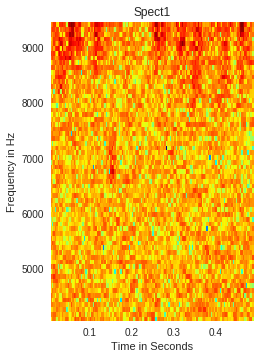

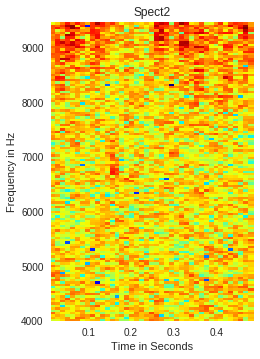

(257, 718)


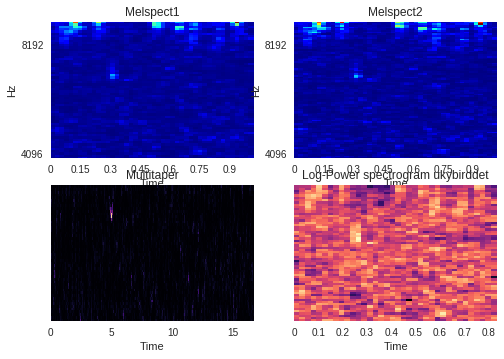

In [193]:
########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek
import librosa
from librosa import display
from librosa.core import power_to_db
image_positive = []
description_positive = []
sum_birds=0
has_bird = 1

for i in range(10,100): #math.floor(nr_of_chunks)): 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  x = range(frame_start,frame_end)
  
  for j in y_read.index.tolist():
    bird_start = int(round(y_read.start[j]*1000))
    bird_end = int(round(y_read.end[j]*1000))
    y = range(bird_start,bird_end)
    
    intersect_start = max(x[0], y[0])
    intersect_end = min(x[-1], y[-1])+1
    range1 = (range(intersect_start, intersect_end))
    
    if len(range1)> minimal_duration: 
      sum_birds = sum_birds+1
      representations(frame)   
      image_positive.append(amplitudes)
      description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])
      
      
      
      if plot ==1:
      # Plot
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
    
#print(sum_birds)
#print(np.shape(description_positive))
#print(np.shape(image_positive))
#print(i,frame_start, frame_end)

In [0]:
########## Usunięcie duplikatów, zakładamy że nie więcej niż 2 głosy w ramce

labels = ['Chunk_nr', 'Chunk_start', 'Chunk_end', 'Call_start_chunk','Call_end_chunk','Call_start','Call_end','Has_bird','2nd_call_start','2nd_call_end']
description_pd = pd.DataFrame.from_records(description_positive, columns=labels)   # na lepszy format

duplic = description_pd[description_pd.duplicated(subset='Chunk_nr',keep=False)]   # wypisanie duplikujących sie ramek (ale z innym glosem zawartym)
duplic_index = duplic.drop_duplicates(subset='Chunk_nr',keep='first')['Chunk_nr'].index.tolist() 
#print(duplic)
#print(duplic_index)

df = description_pd.drop_duplicates(subset='Chunk_nr',keep='first')  # usuwamy drugie duplikaty z listy
for i in duplic_index:
  df['2nd_call_start'][i]= description_pd['Call_start'][i+1]   # dopisujemy drugi głos do ramki
  df['2nd_call_end'][i]= description_pd['Call_end'][i+1]

########## Macierz wyjściowa obrazów i opisów, same ptaki
  
description_positive_no_duplic = df  
image_positive_no_duplic = np.delete(image_positive, (duplic_index), axis=0)
print(np.shape(image_positive_no_duplic))
print((description_positive_no_duplic))

In [0]:
########## Indexy pustych ramek
random.seed(667)
sum_birds = np.shape(image_positive_no_duplic)[0]  # bez powtórzeń już

birds_chunks = description_positive_no_duplic['Chunk_nr'].tolist()
range_nonbirds = [i for i in range(0, math.floor(nr_of_chunks)) if i not in birds_chunks]
nobirds_chunks = random.sample(range_nonbirds, sum_birds)  # dobieramy tyle ramek bez ptaków, co mamy z ptakami
#print(nobirds_chunks)

In [0]:
########## Utworzenie macierzy z ramkami bez ptaków
image_negative = []
description_negative = []

for i in nobirds_chunks: 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  #print(frame_start,frame_end)
  x = range(frame_start,frame_end)

  ## reprezentacja 1 - spektrogram
  freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
  amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
  freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]
      
  image_negative.append(amplitudes)
  description_negative.append([i, frame_start, frame_end, 0, 0, 0, 0, 0, 0, 0])
        
#print(description_negative[:3])
#print(np.shape(description_negative))
#print(np.shape(image_negative))  

In [0]:
########## Złożenie dwóch macierzy i zapis
description_negative_pd = pd.DataFrame.from_records(description_negative, columns=labels)

final_dataset = np.concatenate([image_positive_no_duplic, np.array(image_negative)])
final_description = pd.concat([description_positive_no_duplic,description_negative_pd])

np.save((source_out + nazwa + 'balanced_dataset' ),final_dataset)
np.savez((source_out + nazwa + 'all' ),final_dataset=final_dataset,final_description=final_description, freqs=freqs, times= times, nobirds_chunks=nobirds_chunks)

Chunk_nr               692
Chunk_start         242200
Chunk_end           242700
Call_start_chunk    242251
Call_end_chunk      242273
Call_start          242251
Call_end            242273
Has_bird                 1
2nd_call_start      242618
2nd_call_end        242633
Name: 19, dtype: int64


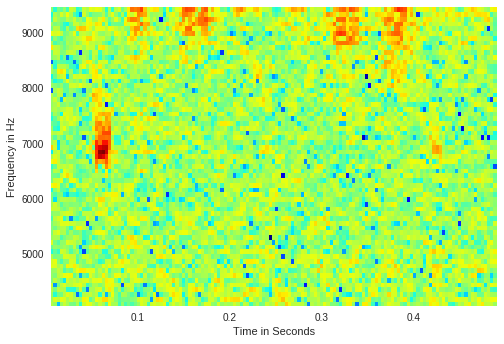

Chunk_nr              1202
Chunk_start         420700
Chunk_end           421200
Call_start_chunk         0
Call_end_chunk           0
Call_start               0
Call_end                 0
Has_bird                 0
2nd_call_start           0
2nd_call_end             0
Name: 121, dtype: int64


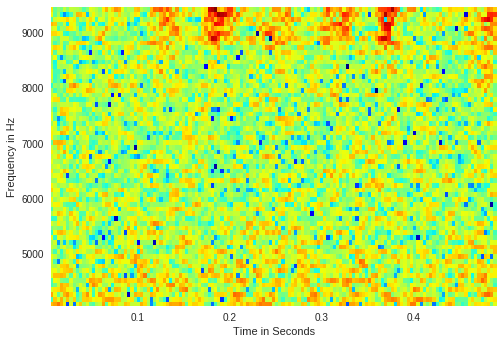

In [0]:
########## Przykład, z ptakiem i bez ptaka
for i in (18, 245):  
  print(final_description.iloc[i])  
  amplitudes = 10 * np.log10(final_dataset[i] + 1e-9)
  plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
  plt.xlabel("Time in Seconds")
  plt.ylabel("Frequency in Hz")
  plt.show()

In [0]:
########## Przykład jak ładować dane

dane1 = np.load(source_out + nazwa + 'balanced_dataset.npy')
opisy1 = np.load(source_out + nazwa + nazwa_out + '.npz' )
fre = opisy1['freqs']
#print(opisy1.files)
#print(fre)


In [0]:
# pięć różnych reprezentacji

# 1. zwykłe spektro
# 2. multitaper